In [1]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import random_rotation, random_shear, random_zoom, random_brightness
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import itertools
import mlflow.tensorflow
import mlflow
import cv2

In [2]:
def prepare_data(data, to_3_channels=True, to_clahe=False):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array in shape(48,48,3) and pixel range(0,256) """
    clahe = cv2.createCLAHE(clipLimit=2)
    channels = 3 if to_3_channels == True else 1

    image_array = np.zeros(shape=(len(data), 48, 48, channels))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1

        #  CLAHE (Contrast Limited Adaptive Histogram Equalization)
        if to_clahe == True:
            image = image[:, :, 0].astype("uint8")
            image = clahe.apply(image)
            image = np.reshape(image, (48, 48, 1))

        # Convert to 3 channels
        if to_3_channels == True:
            image = np.stack(
                [image[:, :, 0], image[:, :, 0], image[:, :, 0]], axis=-1)
        image_processed = preprocess_input(image)
        image_array[i] = image_processed

    return image_array, image_label


def resize_image(img_array, output_shape=(224, 224)):
    output_img = cv2.resize(img_array, output_shape)
    return output_img


def augmentation_image(x):
    tf.random.set_seed(19960220)
    x = random_rotation(x, rg=15, channel_axis=2)  # 旋轉 0~15度
    x = random_brightness(x, (1.1, 1.3))  # 調整明度(1.1~1.3倍)
    x = random_shear(x, intensity=10, channel_axis=2)  # 錯切
    x = random_zoom(x, zoom_range=(0.8, 1), channel_axis=2)  # 縮放(1.00 ~ 1.25倍)
    return x


def auto_augmentation(X_train, y_train, class_sample_size, ratio=1):
    max_class_size = np.max(class_sample_size)
    fill_class_sample_size = [int(ratio*max_class_size - size)
                              for size in class_sample_size]
    X_train_aug_array = []
    y_train_aug_array = []
    for i, fill_size in enumerate(fill_class_sample_size):
        samples = np.random.choice(list(np.where(y_train == i)[0]), fill_size)
        for image in X_train[samples]:
            image_aug = augmentation_image(image)
            X_train_aug_array.append(image_aug)
            y_train_aug_array.append(i)
    X_train_aug_array = np.array(X_train_aug_array)
    y_train_aug_array = np.array(y_train_aug_array)
    return X_train_aug_array, y_train_aug_array


def plot_one_emotion(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion'] == label].index[i]
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def build_model(preModel=EfficientNetB0, pretrained=True, optimizer="ADAM", num_classes=7, input_shape=(48, 48, 3), l2_coef=0.0001):

    pre_model = preModel(include_top=False, weights='imagenet' if pretrained == True else None,
                         input_shape=input_shape,
                         pooling='max', classifier_activation='softmax')

    for layer in pre_model.layers:
        layer.trainable = False

    x = Dropout(0.2)(pre_model.output)

    output = Dense(
        num_classes, activation="softmax", name="main_output",
        kernel_regularizer=regularizers.l2(l2_coef))(x)

    freezed_model = tf.keras.Model(pre_model.input, output)

    top3acc = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3, name="top3acc")

    if optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(
            lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer == "ADAM":
        opt = tf.keras.optimizers.Adam()

    freezed_model.compile(optimizer=opt,
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy', 'MeanSquaredError', 'AUC', top3acc])

    return freezed_model


def step_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    Step decay schedule drops the learning rate by a factor every few epochs.
    """
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 5
    warm_up_epoch = 0
    if epoch+1 < warm_up_epoch:  # warm_up_epoch之前採用warmup
        lr = drop * ((epoch+1) / warm_up_epoch)
    else:  # 每epochs_drop個epoch，lr乘以drop倍。
        lr = lr_init * (drop**(int(((1+epoch)/epochs_drop))))
    return lr


def exp_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    """
    lr_init = 0.001
    lr = lr_init * tf.math.exp(-0.2 * (epoch+1))
    return lr


def poly_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    """
    lr_init = 0.001
    lr_end = 0.00001
    decay_steps = 10
    global_step = epoch
    power = 0.5
    if global_step >= decay_steps:
        global_step = global_step % decay_steps

    lr = (lr_init-lr_end)*((1-(global_step/decay_steps))**power) + lr_end
    return float(lr)


def unfreeze_model(model, n=1, is_unfreeze_BN=False):
    # We unfreeze the top n layers while leaving BatchNorm layers frozen
    # n = 6 (~ block-top)
    # n = 19 (~ block-7)
    if is_unfreeze_BN == False:
        for layer in model.layers[-n:]:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = True
    else:
        for layer in model.layers[-n:]:
            layer.trainable = True

    top3acc = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3, name="top3acc")

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', 'MeanSquaredError', 'AUC', top3acc])


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def save_model(model, save_folder=".", save_name="mymodel"):
    # 儲存模型-tf格式
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    # Save the model.
    with open(save_folder + "/" + save_name + ".tflite", 'wb') as f:
        f.write(tflite_model)

    # 儲存模型-keras格式
    model.save(save_folder + "/" + save_name + ".h5")


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [3]:
#  資料讀取
df_raw = pd.read_csv("D:/mycodes/AIFER/data/FER2013/fer2013.csv")
#  資料前處理
X_train, y_train = prepare_data(df_raw[df_raw['Usage'] == 'Training'])
X_val, y_val = prepare_data(df_raw[df_raw['Usage'] == 'PublicTest'])
y_train_oh, y_val_oh = to_categorical(y_train), to_categorical(y_val)

In [4]:
def prepare_data(data, to_3_channels=True, to_clahe=False):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array in shape(48,48,3) and pixel range(0,256) """
    clahe = cv2.createCLAHE(clipLimit=2)
    channels = 3 if to_3_channels == True else 1

    image_array = np.zeros(shape=(len(data), 48, 48, channels))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))  # 灰階圖的channel數為1

        #  CLAHE (Contrast Limited Adaptive Histogram Equalization)
        if to_clahe == True:
            image = image[:, :, 0].astype("uint8")
            image = clahe.apply(image)
            image = np.reshape(image, (48, 48, 1))

        # Convert to 3 channels
        if to_3_channels == True:
            image = np.stack(
                [image[:, :, 0], image[:, :, 0], image[:, :, 0]], axis=-1)
        image_processed = preprocess_input(image)
        image_array[i] = image_processed

    return image_array, image_label


def resize_image(img_array, output_shape=(224, 224)):
    output_img = cv2.resize(img_array, output_shape)
    return output_img


def augmentation_image(x):
    tf.random.set_seed(19960220)
    x = random_rotation(x, rg=15, channel_axis=2)  # 旋轉 0~15度
    x = random_brightness(x, (1.1, 1.3))  # 調整明度(1.1~1.3倍)
    x = random_shear(x, intensity=10, channel_axis=2)  # 錯切
    x = random_zoom(x, zoom_range=(0.8, 1), channel_axis=2)  # 縮放(1.00 ~ 1.25倍)
    return x


def auto_augmentation(X_train, y_train, class_sample_size, ratio=1):
    max_class_size = np.max(class_sample_size)
    fill_class_sample_size = [int(ratio*max_class_size - size)
                              for size in class_sample_size]
    X_train_aug_array = []
    y_train_aug_array = []
    for i, fill_size in enumerate(fill_class_sample_size):
        samples = np.random.choice(list(np.where(y_train == i)[0]), fill_size)
        for image in X_train[samples]:
            image_aug = augmentation_image(image)
            X_train_aug_array.append(image_aug)
            y_train_aug_array.append(i)
    X_train_aug_array = np.array(X_train_aug_array)
    y_train_aug_array = np.array(y_train_aug_array)
    return X_train_aug_array, y_train_aug_array


def plot_one_emotion(data, img_arrays, img_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion'] == label].index[i]
        axs[i].imshow(img_arrays[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[img_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])


def build_model(preModel=EfficientNetB0,
                pretrained=True,
                optimizer="ADAM",
                num_classes=7,
                input_shape=(48, 48, 3),
                l2_coef=0.0001):

    pre_model = preModel(include_top=False, weights='imagenet' if pretrained == True else None,
                         input_shape=input_shape,
                         pooling='max', classifier_activation='softmax')

    for layer in pre_model.layers:
        layer.trainable = False

    x = Dropout(0.2)(pre_model.output)

    output = Dense(
        num_classes, activation="softmax", name="main_output",
        kernel_regularizer=regularizers.l2(l2_coef))(x)

    freezed_model = tf.keras.Model(pre_model.input, output)

    top3acc = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3, name="top3acc")

    if optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(
            lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer == "ADAM":
        opt = tf.keras.optimizers.Adam()

    freezed_model.compile(optimizer=opt,
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy', 'MeanSquaredError', 'AUC', top3acc])

    return freezed_model


def step_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    Step decay schedule drops the learning rate by a factor every few epochs.
    """
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 5
    warm_up_epoch = 0
    if epoch+1 < warm_up_epoch:  # warm_up_epoch之前採用warmup
        lr = drop * ((epoch+1) / warm_up_epoch)
    else:  # 每epochs_drop個epoch，lr乘以drop倍。
        lr = lr_init * (drop**(int(((1+epoch)/epochs_drop))))
    return lr


def exp_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    """
    lr_init = 0.001
    lr = lr_init * tf.math.exp(-0.2 * (epoch+1))
    return lr


def poly_decay(epoch):
    """
    Warm-up applying high learning rate at first few epochs.
    """
    lr_init = 0.001
    lr_end = 0.00001
    decay_steps = 10
    global_step = epoch
    power = 0.5
    if global_step >= decay_steps:
        global_step = global_step % decay_steps

    lr = (lr_init-lr_end)*((1-(global_step/decay_steps))**power) + lr_end
    return float(lr)


def unfreeze_model(model, n=1, is_unfreeze_BN=False):
    # We unfreeze the top n layers while leaving BatchNorm layers frozen
    # n = 6 (~ block-top)
    # n = 19 (~ block-7)
    if is_unfreeze_BN == False:
        for layer in model.layers[-n:]:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = True
    else:
        for layer in model.layers[-n:]:
            layer.trainable = True

    top3acc = tf.keras.metrics.TopKCategoricalAccuracy(
        k=3, name="top3acc")

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', 'MeanSquaredError', 'AUC', top3acc])


def ckpt(test_name="test"):
    if not os.path.exists("./checkpoints/"+test_name):
        os.makedirs("./checkpoints/"+test_name)
    checkpoint = ModelCheckpoint("./checkpoints/"+test_name+"/model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.h5",
                                 monitor='val_accuracy', verbose=1,
                                 save_best_only=True, save_weights_only=False, mode='max')
    return checkpoint


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def save_model(model, save_folder=".", save_name="mymodel"):
    # 儲存模型-tf格式
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    # Save the model.
    with open(save_folder + "/" + save_name + ".tflite", 'wb') as f:
        f.write(tflite_model)

    # 儲存模型-keras格式
    model.save(save_folder + "/" + save_name + ".h5")


emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [5]:
# 二階段式訓練(微調 block-top layers -> block-7 layers)
unfreeze_n = [6, 19]
phase_epochs = [15, 30]
phase_batch_size = [32, 32]
phases = len(phase_epochs)

model = build_model()
rum_name = "2StepsToBlock7"
for i in range(phases):
    unfreeze_model(model, n=unfreeze_n[i], is_unfreeze_BN=False)
    with mlflow.start_run(experiment_id=1, run_name=f"{rum_name}_phase{i+1}"):

        mlflow.tensorflow.autolog()
        hist = model.fit(X_train, y_train_oh,
                         validation_data=(X_val, y_val_oh),
                         initial_epoch=0 if i == 0 else phase_epochs[i-1],
                         epochs=phase_epochs[i],
                         batch_size=phase_batch_size[i])
    mlflow.end_run()

Epoch 1/15
  1/898 [..............................] - ETA: 0s - loss: 2.0506 - accuracy: 0.1875 - mean_squared_error: 0.1275 - auc: 0.5117 - top3acc: 0.4688WARNING:tensorflow:From C:\Users\USER\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
898/898 [==============================] - 44s 49ms/step - loss: 1.5695 - accuracy: 0.3957 - mean_squared_error: 0.1046 - auc: 0.7760 - top3acc: 0.7404 - val_loss: 1.4708 - val_accuracy: 0.4335 - val_mean_squared_error: 0.0993 - val_auc: 0.8059 - val_top3acc: 0.7687
Epoch 2/15
898/898 [==============================] - 36s 40ms/step - loss: 1.4459 - accuracy: 0.4485 - mean_squared_error: 0.0976 - auc: 0.8146 - top3acc: 0.7876 - val_loss: 1.4125 - val_accuracy: 0.4642 - val_mean_squared_error: 0.0955 - val_auc: 0.8242 - val_top3a

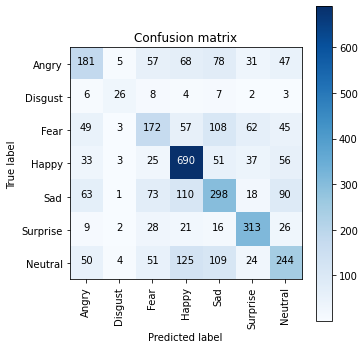

In [6]:
# 混淆矩陣
y_prob_val = model.predict(X_val)
y_pred_val = np.argmax(y_prob_val, axis=1)
plot_confusion_matrix(confusion_matrix(y_val, y_pred_val),
                      classes=list(emotions.values()))

In [7]:
# 二階段式訓練(微調 block-top layers -> all layers)
unfreeze_n = [6, 1000]
phase_epochs = [15, 30]
phase_batch_size = [32, 32]
phases = len(phase_epochs)

model = build_model()
rum_name = "2StepsToAll"
for i in range(phases):
    unfreeze_model(model, n=unfreeze_n[i], is_unfreeze_BN=False)
    with mlflow.start_run(experiment_id=1, run_name=f"{rum_name}_phase{i+1}"):

        mlflow.tensorflow.autolog()
        hist = model.fit(X_train, y_train_oh,
                         validation_data=(X_val, y_val_oh),
                         initial_epoch=0 if i == 0 else phase_epochs[i-1],
                         epochs=phase_epochs[i],
                         batch_size=phase_batch_size[i])
    mlflow.end_run()

Epoch 1/15
898/898 [==============================] - 34s 38ms/step - loss: 1.5656 - accuracy: 0.3941 - mean_squared_error: 0.1043 - auc: 0.7777 - top3acc: 0.7436 - val_loss: 1.4970 - val_accuracy: 0.4316 - val_mean_squared_error: 0.1006 - val_auc: 0.8008 - val_top3acc: 0.7726
Epoch 2/15
898/898 [==============================] - 30s 33ms/step - loss: 1.4461 - accuracy: 0.4454 - mean_squared_error: 0.0978 - auc: 0.8146 - top3acc: 0.7867 - val_loss: 1.4302 - val_accuracy: 0.4575 - val_mean_squared_error: 0.0965 - val_auc: 0.8186 - val_top3acc: 0.7885
Epoch 3/15
898/898 [==============================] - 28s 31ms/step - loss: 1.3963 - accuracy: 0.4654 - mean_squared_error: 0.0949 - auc: 0.8290 - top3acc: 0.8045 - val_loss: 1.4373 - val_accuracy: 0.4436 - val_mean_squared_error: 0.0974 - val_auc: 0.8197 - val_top3acc: 0.7955
Epoch 4/15
898/898 [==============================] - 25s 28ms/step - loss: 1.3570 - accuracy: 0.4834 - mean_squared_error: 0.0926 - auc: 0.8401 - top3acc: 0.8209 - v

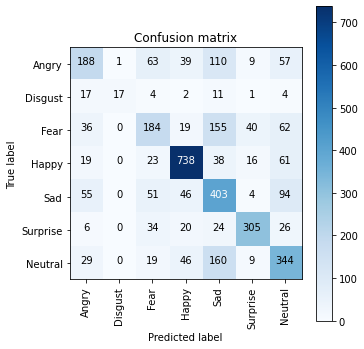

In [8]:
# 混淆矩陣
y_prob_val = model.predict(X_val)
y_pred_val = np.argmax(y_prob_val, axis=1)
plot_confusion_matrix(confusion_matrix(y_val, y_pred_val),
                      classes=list(emotions.values()))